# 3.6 주택 가격 예측: 회귀 문제
- 연속적인 값을 예측하는 **회귀**(regression)

## 3.6.1 보스턴 주택 가격 데이터셋
- 1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율, 주택당 평균 방의 개수, 고속도로 접근성 등의 데이터로 주택 가격의 중간 값 예측
- 404개 훈련 샘플, 102개 테스트 샘플

In [1]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [2]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [3]:
print(train_targets)

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

## 3.6.2 데이터 준비
- 상이한 스케일을 가진 값을 신경망에 주입하면 학습을 어렵게 만든다.
    - 전역 최소 점을 찾아가는 경사 하강법의 경로가 스케일이 큰 특성에 영향을 많이 받음
- 특성별로 표준화

### 데이터 정규화하기
- 훈련 데이터를 정규화할 때 사용한 값을 테스트 데이터에 그대로 사용
    - 절대 테스트 데이터로 구한 값을 사용하면 안 됨

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 3.6.3 모델 구성
- 샘플 수가 작기 때문에 64개의 유닛을 가진 2개의 은닉 층으로 작은 네트워크 구성
- 훈련 데이터 수가 적을수록 과적합이 더 쉽게 일어나므로 작은 모델을 사용

### 모델 정의
- 스칼라 회귀 모델의 마지막 층은 활성화 함수가 없음
- `mse` : **평균 제곱 오차**(mean squared error)
- `mae` : **평균 절대 오차**(mean absolute error)

In [5]:
from tensorflow.keras import models, layers

# 동일한 모델을 여러 번 생성할 용도의 함수
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1], )))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## 3.6.4 K-겹 검증을 사용한 훈련 검증
- 데이터가 많기 않기 때문에 검증 세트도 매우 작아짐
- 그렇기 때문에 어떤 데이터가 검증용으로 선택되냐에 따라 검증 점수의 분산이 높아짐
- **K-겹 교차 검증**(K-fold cross-validation)을 사용하여 K개 분할(폴드)로 나누고 K-1개의 분할에서 훈련, 나머지 분할에서 평가
    - 모델의 검증 점수는 K개의 검증 점수 평균

In [6]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리 중인 폴드 #', i)
    
    # 검증 데이터
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    # 훈련 데이터
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1) * num_val_samples:]],
        axis = 0)
    
    model= build_model()
    # verbose=0 : 훈련 과정 출력 X
    model.fit(partial_train_data, partial_train_targets,
             epochs = num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리 중인 폴드 # 0
처리 중인 폴드 # 1
처리 중인 폴드 # 2
처리 중인 폴드 # 3


In [7]:
all_scores

[1.828141450881958, 2.4349546432495117, 2.4487404823303223, 2.2739551067352295]

In [8]:
np.mean(all_scores)

2.2464479207992554

#### 결과 해석
- 평균 2,240달러로, 주택 가격 범위가 1만~5만임을 감안하면 비교적 큰 값

### 각 폴드에서 검증 점수를 로그에 저장하기
- 500 에포크 동안, 각 에포크마다 모델이 얼마나 개선되는지 로그로 저장

In [11]:
%%time

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리 중인 폴드 #', i)
    
    # 검증 데이터
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    # 훈련 데이터
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i+1) * num_val_samples:]],
        axis = 0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i+1) * num_val_samples:]],
        axis = 0)
    
    model= build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data = (val_data, val_targets),
                        epochs = num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리 중인 폴드 # 0
처리 중인 폴드 # 1
처리 중인 폴드 # 2
처리 중인 폴드 # 3
Wall time: 19min 35s


### K-겹 검증 점수 평균을 기록하기

In [12]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

### 검증 점수 그래프

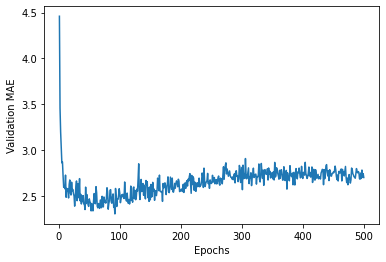

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기
- 곡선의 다른 부분과 스케일이 다른 첫 10개의 데이터 포인트 제외
- 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 **지수 이동 평균**(exponential moving average)로 대체
    - 지수 이동 평균 : 시계열 데이터를 부드럽게 만드는 기법 중 하나로, 이전에 계산된 이동 평균에 factor를 곱하고 현재 포인트에 (1-factor)를 곱해 합산한 것

In [14]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

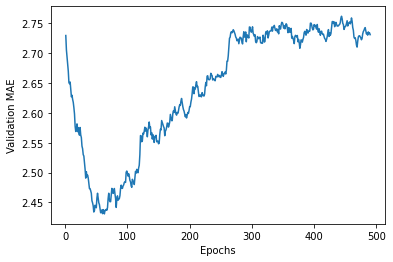

In [15]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

- 80번째 에포크 이후에 MAE가 줄어들지 않음 (과대적합의 시작)

### 최종 모델 훈련하기
- 에포크 수, 은닉 층의 크기 등 매개변수에 대한 K-겹 검증 튜닝이 끝나면 모든 훈련 데이터를 사용하고 최상의 매개변수로 최종 실전에 투입될 모델을 훈련시킴

In [16]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 19.3230 - mae: 2.6436


In [17]:
test_mae_score

2.643617630004883